(chap:18-adas-1)=
# 定量的マクロ経済分析：Part 1

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [3]:
import japanize_matplotlib
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# numpy v1の表示を使用
np.set_printoptions(legacy='1.21')
# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

## はじめに

本章と次章の目的は，回帰分析，差分方程式，ランダム変数を駆使し，定量（数量）的マクロ経済分析をおこなうことである。使うモデルは，中級レベルのマクロ経済学ではお馴染みの総需要・総供給モデル（ADASモデル）である。より具体的には，次の２ステップに分けて定量分析をおこなう。
1. 景気循環に関するデータに基づきADASモデルのパラメーターの値を設定するカリブレーションと呼ばれる作業をおこなう。
1. ADASモデルの数量的な特徴を確認し，次の問いを検討する。

    > GDPと価格水準の長期トレンドからの乖離（％）の変動は，何パーセントが需要ショックにより引き起こされ，何パーセントが供給ショックに起因するのか？

本章では１について解説をおこない，次章で２について議論を展開する。

通常の教科書でのADASモデルを使う分析では，パラメータの符号（正か負）のみを仮定し，比較静学に基づきモデルの定性的な特徴や予測を考察する。例えば，政府支出の増加を考えてみよう。利子率は上昇し，短期的にはGDPも増加することになるが，「GDPの増加」は定性的な結果（予測）である。このような分析は経済を理解する上で有用な方法であるが，例えば，「GDPがどれだけ増加するのか」について答えることはできない。GDPの増分がどの程になるのかは，定量的な問題（予測）であり，総需要曲線と総供給曲線の傾き等の値を設定してこそ答えることができる問いである。

一方で，パラメータにランダムな値を使っても意味がある分析にはならない。そこで有用な手法がカリブレーションと呼ばれる分析方法である。詳細は以下で説明するが，簡単に言うと，カリブレーションではマクロ・データの特徴と整合的にパラメータの値を決定することになる。本章では，カリブレーションの考え方と中級＋レベルで使えるツールを利用した方法を解説する。一旦，パラメータの値が決まるとより興味深い定量分析が可能となるが，次章で扱うことにする。

```{note}
ADASモデルの総需要曲線はISLMモデル（もしくは開放経済版であるマンデル＝フレミング・モデル）から導出できる。即ち，ADASモデルの裏ではISLMモデルが動いているため，ADAS-ISLMと表現することもできる。一方で，殆どの大学院のマクロ経済学の授業ではADAS-ISLMモデルは学ばないのではないだろうか。その大きな理由は，合理的期待に基づく消費者・企業の最適化行動が明示的に反映されていないことである。その反動かもしれないが，ADAS-ISLMモデルは「初学者用」と思われる傾向がある。しかし実際には，政策を検討する際にADAS-ISLMモデルは参考にされている。内閣府は「経済環境の変化や財政金融政策が経済に与える影響を定量的に評価するため」に[短期日本経済マクロ計量モデル](https://www.esri.cao.go.jp/jp/esri/prj/current_research/short_macro/index.html)を研究テーマとして挙げており，そこで展開されるのはADAS-ISLMモデルの開放経済版（マンデル＝フレミング・モデル）である。もちろん，変数や式の数は比べものにならない程大掛かりなモデルとなっているが，基本的にはADAS-ISLMモデルである。
```

```{hint}
論文[『経済マクロモデルについて ~その概要、歴史、シミュレーション等~』](https://www.sangiin.go.jp/japanese/annai/chousa/keizai_prism/backnumber/r03pdf/202120003.pdf)は，マクロ経済学において影響力があるモデルの歴史的な発展と現状について端的にわかり易く解説している。論文が掲載された[「経済のプリズム」](https://www.sangiin.go.jp/japanese/annai/chousa/keizai_prism/backnumber/index.html)という雑誌は参議院事務局が編集・発行しており，政治家を主な読者としているためか，難しい数式は一切ない。興味がある人は是非読んでみよう。
```

## ADASモデル

ここでは総需要・総供給モデル（ADASモデル，Aggregate Demand and Aggregate Supply Model）の記号を整理し，景気循環データと整合性が保たれるように内生変数を解釈し直すことにより，定量分析の準備をおこなう。

### モデルの構造

#### 短期総供給曲線（AS曲線）

$$
P_t=P_{t}^e+a(Y_t-Y_{*})+v_t,\qquad a>0
$$(eq:18-as)

* $Y_t=$ 産出量の対数
* $Y_{*}=$ 自然産出量の対数
    * 資本蓄積や技術進歩などにより決定される。
    * トレンドに対応する。
    * ADASモデルでは一定と仮定する。下で仮定する需要ショックは一時的なものであり，トレンドには影響しないと仮定する。
* $P_t=$ 物価水準の対数
* $P_{*}=$ 物価水準の対数
    * トレンドに対応する。
    * ここでは一定と仮定する。下で仮定する供給ショックは一時的なものであり，トレンドには影響しないと仮定する。
* $v_t=$ 供給ショック

式[](eq:18-as)自体はAS曲線の典型的な式となっている。一方で，定量分析のために次の点に関して解釈し直している。
* 変数の定義：
    * 内生変数である$Y_t$と$P_t$は産出量と物価水準の対数としている。同様に，$Y_{*}$，$P_{*}$，$P_t^{e}$も対数としている。対数として解釈することにより，ADASモデルを使ってデータを捉えやすくする利点があるためである。また，より複雑な非線形のADASモデルを均衡周辺でテイラー近似した結果と解釈しても良いだろう。テイラー近似の手法は，研究で広く用いられる方法である。
* 産出量の長期的水準：
    * 長期均衡での産出量は自然産出量$Y_{*}$で与えられるが，これはGDPのトレンドと解釈する。以下の分析では，PHフィルターで計算した値を使うことになる。
    * 通常のADASモデルの仮定に沿って，総供給ショック$v_t$は$Y_{*}$に影響を与えないとする。即ち，ここでの総供給ショックは，産出量と物価水準がトレンドから乖離する要因となるものであり，その効果は長期的な効果はないと仮定する。言い換えると，トレンドに影響を及ぼす供給ショックもあり得る訳だが，それらは対象とはなっていないことになる。
* 物価水準の長期的水準：
    * ADASモデルでの長期的な物価水準とは$Y_t=Y_{*}$が満たされる$P_t$であり，基本的にはどのような値をとっても構わない。例えば，総供給ショック$v_t$が`0`から`0.5`に増加（不利な総供給ショック）し，`0.5`が永続的に続く場合，長期的な物価水準は永続的に高くなる。しかし，ここで考える総供給ショック$v_t$は一過性のショックと仮定する。即ち，ある時は`0.3`や`-0.1`などの値を取るが，それは短期的な現象であり，長期的には`0`に戻ると仮定する。この仮定により，長期的な物価水準$P_{*}$が存在することになり，それを物価水準のトレンドだと解釈する。産出量と同様に，HPフィルターを使って物価水準の長期的なトレンドを算出することになる。

#### 総需要曲線（AD曲線）

$$
Y_t=b-c P_t + u_t, \qquad b,c>0
$$(eq:18-ad)

* $u_t=$ 総需要ショック

AD曲線はIS-LMモデルから導出することができるが，その場合，政府支出やマネーストックなど様々な変数に依存した複雑な式となる。式[](eq:18-ad)は対数線形の簡単な式となっているが，その裏にあるのが次の考え方である。
* 政府支出や租税，マネーストック，更には，消費や投資水準はパラメータである$b$と$c$に含まれていると考える。また，それらの変化は全て総需要ショック$u_t$が捉えていると仮定する。
* 総供給ショック$v_t$と同様に，総需要ショック$u_t$は長期的な産出量水準には影響は与えないと仮定を置くとともに，ショック自体も永続的に維持されるのではなく，時間とともにフェードアウトする短期的ショックと仮定する。

このように簡略化することにより，景気循環データをADASモデルの枠組みの中で扱いやすくなる利点がある。

#### 適応的期待

$$
P_t^e= P_{t-1}
$$(eq:18-pe)

適応的期待は「後ろ向き」の期待形成を仮定することになり，批判の的にもなり易い。しかし，最前線の研究でも取り上げられる場合があり，データの特徴を捉えた仮定と言えるだろう。

#### 総需要・総供給ショック

既に触れたが，ショック項$u_t$と$v_t$は次の2点を満たすと仮定する。
* 自然産出量$Y_{*}$に影響を及ぼさない。
* 短期的なショックであり，永続的に正または負の一定の値を取り続けない。

この２つの仮定は，$u_t$または$v_t$が`0`以外の値を取った場合，`0`に戻せば満たされることになる。

一方で，確率的シミュレーションを行う際は，毎期毎期において総需要ショックと総供給ショックが発生する状況を考える。その場合，次の２つの仮定の内の一つを採用することになる。
1. ホワイト・ノイズ

$$
\begin{aligned}
u_t&\sim\text{N}(0,\sigma_u^2)\\
v_t&\sim\text{N}(0,\sigma_v^2)
\end{aligned}
$$

2. AR(1)自己回帰モデル

$$
\begin{aligned}
u_t&=\rho_u u_{t-1}+e_{ut},\qquad u_t\sim\text{N}(0,\sigma_{eu}^2)\\
v_t&=\rho_v v_{t-1}+e_{vt},\qquad v_t\sim\text{N}(0,\sigma_{ev}^2)
\end{aligned}
$$

この章でおこなう確率的シミュレーションではホワイト・ノイズを仮定するが，AR(1)を使う場合は付録で扱うことにする。

```{note}
マクロ計量経済学の分野にベクトル自己回帰モデル（VAR, Vector Autoregression）と呼ばれる手法がある。その文献における「構造ショック」と$u_t$及び$v_t$がどう異なるかを考えてみよう。

VARモデルには構造型VARモデルと誘導型VARモデルの２つがあるが，ここで考えるのは前者である。その考え方を簡単に説明するために，例としてGDPと失業率の２変数のVARモデルを考えてみよう。構造型VARでは，$t$期のGDPは（i）$t$期の失業率，（ii）２変数の過去の値，（iii）$t$期のGDPショックの３つに依存すると考える。同様に，$t$期の失業率は同期のGDP，２変数の過去の値，そして失業率ショックに依存する。ここで重要になるのが次の点である。（ii）で使用する変数が十分に過去を遡った値（例えば，四半期データで$t-1$期から$t-3$期もしくは更に遡った値）であれば，（iii）のショックが次の３つの特徴を満たすということである。
1. 均一分散
1. 自己相関はない
1. GDPショックと失業率ショックは無相関

このようなショックを「構造ショック」と呼ぶ。なぜそう呼ばれるかを直感的に考えてみよう。経済メカニズムにより発生する変数の動きは，時間的なラグが存在したり（例えば，雇用の調整にはコストが掛かるが，それが非常に高い失業率の持続性の一つの要因と考えられる），他の変数の過去の値から影響を受けたりする（例えば，失業している間に労働者のスキルは失われ，それが将来のGDPに負の影響を及ぼす可能性がある）。このような経済メカニズムに起因する効果を捉えたのが（ii）の過去の変数である。２変数の時間的なラグが十分に長くなれば，殆どの経済メカニズムの効果は捉えることができるため，残っているのは（iii）にある経済メカニズムと無関係な純粋にランダムはショックということになる。それを「構造ショック」としてGDPショック，失業率ショックと呼んでいる。

ADASモデルの$u_t$と$v_t$はどうかというと，ADASモデルには十分な変数のラグが無いため上の「構造ショック」の３つの特徴を必ずしも満たすとは限らない。むしろ，$u_t$には$p_t$で捉えられていない政府，中央銀行，企業や消費者の$y_t$（$Y_t$のトレンドからの乖離）に対する影響を全て反映しており，ここではそれを総需要ショックと呼んでいる。同様に，$v_t$は適応的期待と$y_t$で捉えられていない，企業などの$p_t$（$P_t$のトレンドからの乖離）に対する影響を総需要ショックと呼んでいる。即ち，$u_t$と$v_t$には経済メカニズムにより発生するショックを含んでいると考えることができる。従って，$u_t$と$v_t$は，VARモデルでいう構造ショックとは異なることになる。
```

#### 長期均衡

長期均衡または定常状態（steady state）では次の条件が満たされることになる。
* $u_{t}=v_t=0$：ショックはない
* $P_t=P_*$
* $Y_t=Y_*$

#### 図示

ADASモデルを図示すると{numref}`fig:18-adas0`のようになる。長期均衡においてAD曲線とAS曲線は$P_*$と$Y_*$で交差することになる。短期均衡を考えるために，総供給ショック$v_t$が１期間だけ正の値を取り，その後は`0`になるとしよう。ショックが発生するとAS曲線は上方シフトし，産出量は減少し物価水準は上昇する。適応的期待により，ショックがなくなってもAS曲線は直ぐには長期均衡に戻らず，徐々に下方シフトすることになり，最終的には長期均衡に経済は戻ることになる。

このような分析は，教科書で解説される典型的な例である。長期均衡は安定的であり，産出量と物価水準は少しずつ動くという結果は直感的であり，わかり易い。しかし，このような定性的な分析からは，ショック発生後に経済はどれだけの時間をかけて長期均衡に戻るかについては何もわからない。また，長期均衡に戻るスピードが何に依存しているのかも分からない。AD曲線とAS曲線の傾きが影響を及ぼしそうだと想像できるが，傾きが急だと戻るスピードが早いのだろうか，遅いのだろうか。このような問は，定量分析をおこなうことにより簡単に確認することが可能となる。

```{figure} /images/adas0.jpg
---
scale: 10%
name: fig:18-adas0
---
産出量と物価水準で表したADASモデル
```

### 均衡式

ADASモデルとデータと整合性があるようにするために次の変数を定義しよう。
* $p_t=P_t-P_*$：価格水準のトレンドからの乖離率
* $y_t=Y_t-Y_*$：産出量のトレンドからの乖離率

$p_t$と$y_t$を使ってAS曲線とAD曲線を書き換えることにする。

#### AS曲線

式[](eq:18-as)に式[](eq:18-pe)を使い次の１行目となる。

$$
\begin{aligned}
P_{t}&=P_{t-1}+a(Y_{t}-Y_{*})+v_t \\
&\Downarrow\quad\text{両辺から$P_{*}$を引く}\\
P_{t}-P_{*}&=(P_{t-1}-P_{*})+a(Y_{t}-Y_{*})+v_t
\end{aligned}
$$

$$
\begin{aligned}
&\Downarrow\quad\text{上の定義を使う}\\
\\
p_t &= p_{t-1}+ay_t +v_t
\end{aligned}
$$ (eq:18-as_small)

この式はAS曲線を産出量と物価水準のトレンドからの乖離率で表している。また，この式から次のことが言える。
* $p_{t-1}$と$y_t$を所与とすると，総供給ショック$v_t$の１単位は物価水準のトレンドからの乖離を１％発生させる。

（理由）$p_{t-1}$と$y_t$を一定として$v_t=1$とすると，$p_t=1$となる。

#### AD曲線

まず長期均衡でのAD曲線を考えてみよう。

$$
Y_{*}=b-c P_{*} 
$$ (eq:18-adss)

$u_t=0$となるため，上の式が成立することになる。

次に，式[](eq:18-ad)の両辺から$Y_{*}$を引くと次式となる。

$$Y_t-Y_*=b-Y_*-c P_t + u_t$$

また左辺の$b-Y_{*}$を削除するために式[](eq:18-adss)を使うと

$$
Y_t-Y_*=cP_*-c P_t + u_t
$$

となり，上の定義を使い次式を導出できる。

$$
y_t=-cp_t + u_t
$$ (eq:18-ad_small)

この式はAD曲線を産出量と物価水準のトレンドからの乖離率で表している。また，この式から次のことが言える。
* $p_{t}$を所与とすると，総需要ショック$u_t$の１単位はGDPのトレンドからの乖離を１％発生させる。

#### 長期均衡

長期均衡または定常状態（steady state）では次の条件が満たされることになる。
* $u_{t}=v_t=0$：ショックはない
* $p_* =0$：トレンドからの乖離率はゼロ
* $y_* =0$：トレンドからの乖離率はゼロ

#### 図示

ADASモデルを乖離率の変数$p_t$と$y_t$で表した図が{numref}`fig:18-adas1`である。原点が長期均衡となる。{numref}`fig:18-adas0`と同じように，総供給ショック$v_t$が１期間だけ正の値を取り，その後は`0`になる場合を考えてみよう。ショックが発生するとAS曲線は上方シフトし，産出量の乖離率は負の値となるが，物価水準の乖離率は正の値を取ることになる。ショックが`0`に戻った後，AS曲線は徐々に下方シフトし，最終的には長期均衡（原点）に経済は戻ることになる。以下の分析では，乖離率の変数である$p_t$と$y_t$を使うが，{numref}`fig:18-adas1`を念頭に置き結果を解釈するとわかり易いだろう。

```{figure} /images/adas1.jpg
---
scale: 10%
name: fig:18-adas1
---
産出量と物価水準のトレンドからの乖離率で表したADASモデル
```

## 景気循環のデータ

### トレンドからの乖離率

この章では式[](eq:18-as_small)と式[](eq:18-ad_small)を使い定量分析をおこなうが，まず，それらの式と整合性があるデータの特徴を考える。$y_t$と$p_t$はトレンドからの乖離率となるため，`py4macro`の`trend()`関数を使い，対応する変数を作成することにする。

In [4]:
df = py4macro.data('jpn-q')

In [5]:
df.columns

Index(['gdp', 'consumption', 'investment', 'government', 'exports', 'imports',
       'capital', 'employed', 'unemployed', 'unemployment_rate', 'hours',
       'total_hours', 'inflation', 'price', 'deflator'],
      dtype='object')

$Y_t$には`gdp`を使い，$P_t$には`deflator`を使うことにする。

次のコードで作成する`gdp_cycle`と`deflator_cycle`は，`0`を中心に上下する系列となる。

In [6]:
for c in ['gdp','deflator']:
    
    df[c+'_cycle'] = np.log(df[c]) - py4macro.trend( np.log(df[c]) )
    
df.head()

,gdp,consumption,investment,government,exports,imports,capital,employed,unemployed,unemployment_rate,hours,total_hours,inflation,price,deflator,gdp_cycle,deflator_cycle
,,,,,,,,,,,,,,,,,
1980-01-01,269747.5,153290.7,65029.2,73039.5,18383.8,24278.8,833041.425949,5506.000000,107.666667,1.900000,124.7,686598.200000,5.766667,71.011939,91.2,0.003269,-0.025798
1980-04-01,268521.8,153551.9,65316.6,72164.5,18631.4,25454.5,843748.581006,5525.666667,110.000000,1.966667,124.8,689603.200000,8.166667,72.917251,93.4,-0.010845,-0.006555
1980-07-01,274183.1,155580.0,65765.9,72663.8,18449.3,23885.7,855449.381902,5561.333333,116.000000,2.033333,124.0,689605.333333,8.200000,73.897654,94.4,0.000457,-0.000482
1980-10-01,279601.8,156162.4,66017.5,74761.1,19705.4,23716.5,867991.306098,5551.333333,123.333333,2.166667,124.0,688365.333333,8.100000,74.767147,95.4,0.010468,0.005515
1981-01-01,281995.7,156757.7,66259.0,76127.6,20289.5,24174.1,878387.487376,5568.666667,124.333333,2.200000,123.6,688287.200000,6.833333,75.690241,95.6,0.009441,0.003126


`gdp_cycle`と`deflator_cycle`をプロットし，データのイメージを掴んでおこう。

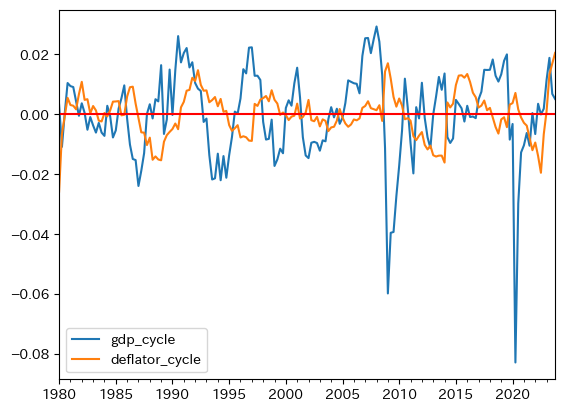

In [7]:
ax_ = df.plot(y=['gdp_cycle','deflator_cycle'])
ax_.axhline(0, color='red')
pass

以下では，`gdp_cycle`と`deflator_cycle`の３つの特徴に焦点を当て議論を進めることにする。

### データの特徴１

In [1]:
y_std = df.loc[:,'gdp_cycle'].std()
p_std = df.loc[:,'deflator_cycle'].std()
print(f'GDPのトレンドからの乖離率の標準偏差：{y_std:.6f}')
print(f'デフレータのトレンドからの乖離率の標準偏差：{p_std:.6f}')

# 不偏分散の平方根

NameError: name 'df' is not defined

２つの数値を比べると，GDPの乖離率の標準偏差はデフレーターの約2倍あることが分かる。これは上のプロットで`gdp_cycle`の変動幅が大きいことを反映している。

### データの特徴２

In [9]:
y_autocorr = df.loc[:,'gdp_cycle'].autocorr()
p_autocorr = df.loc[:,'deflator_cycle'].autocorr()
print(f'GDPのトレンドからの乖離率の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの乖離率の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの乖離率の自己相関係数：0.697
デフレータのトレンドからの乖離率の自己相関係数：0.830


失業やインフレ率などのマクロの変数は、前期の値が高ければ（低ければ）今期も高い（低い）傾向にあるが、この特徴を持続性（persistence; 慣性とも訳される）と呼ぶ。自己相関係数は持続性をとらえており、上の数値はデフレータの方がより高い持続性があることを意味する。

### データの特徴３

In [10]:
yp_corr = df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]
print(f'GDPとデフレータの乖離率の相関係数：{yp_corr:.3f}')

GDPとデフレータの乖離率の相関係数：-0.153


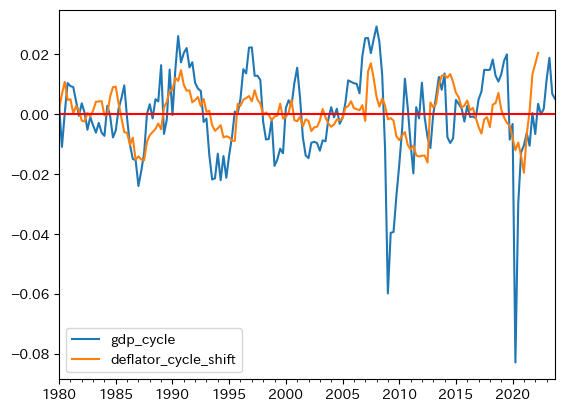

In [13]:
from myst_nb import glue
t_shift = 6
tmp = df.copy()
tmp['deflator_cycle_shift'] = tmp['deflator_cycle'].shift(-t_shift)
ax_ = tmp[['gdp_cycle', 'deflator_cycle_shift']].plot()
ax_.axhline(0, color='red')
yp_corr_shift = tmp[['gdp_cycle', 'deflator_cycle_shift']].corr().iloc[0,1]

glue("t_shift", t_shift, display=False)
glue("yp_corr_shift", round(yp_corr_shift.item(),3), display=False)

この値は同じ期の相関係数であり，絶対値は小さく弱い関係にある。しかし，直感的には`gdp_cycle`と`deflator_cycle`の正の相関をイメージするのではないだろうか。正のGDPの乖離率は景気が良いことを示しているため，物価水準であるデフレーターもトレンドから正の方向に乖離するのではないか，という考えである。そのような考え方は基本的には正しいと言えるだろう。ただ，データを見る限り時間のズレがあるようだ。プロットを見ると，正の方向にGDPの乖離率が発生した後にデフレーターの正の乖離が発生しているように見える。次のプロットは，$t$期の`gdp_cycle`と$t+${glue:}`t_shift`期の`deflator_cycle`を重ねて図示している。同じ方向に動いていることを示しているとともに，相関係数も約{glue:}`yp_corr_shift`となっており，正の相関を数値でも確認できる。一つの可能性として次の解釈が成り立つ。デフレーターの変化には時間がかかり，それは価格の粘着性の反映かもしれない。

GDPと6期先のデフレータの乖離率の相関係数：0.433


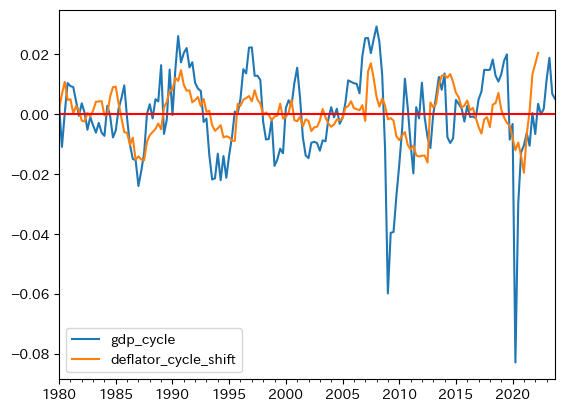

In [14]:
t_shift = 6
tmp = df.copy()
tmp['deflator_cycle_shift'] = tmp['deflator_cycle'].shift(-t_shift)
ax_ = tmp.plot(y=['gdp_cycle', 'deflator_cycle_shift'])
ax_.axhline(0, color='red')
yp_corr_shift = tmp[['gdp_cycle', 'deflator_cycle_shift']].corr().iloc[0,1]
print(f'GDPと{t_shift}期先のデフレータの乖離率の相関係数：{yp_corr_shift:.3f}')

> これらのデータの特徴１〜３をどこまで**再現**できるかに基づいてADASモデルを評価することになる。

## カリブレーション

### はじめに

定量分析を進めるためには，ADASモデルのパラメータに値を設定する必要がある。
ここでは景気循環のデータに基づき，次の4つのパラメーターの値を決めていく
* $a$，$c$，$\sigma_u$，$\sigma_v$ （標準偏差）

パラメーターの値の決め方には主に次の２つある。
1. データに基づいて計量経済学的な手法などを用いて推定した結果を使う。
1. 既存の実証研究で報告され推定値を使う。

多くの研究の場合，これらの方法を駆使して値を決めることになる。
また，必ずしも対象の経済モデルに基づいた推定結果でなくとも構わない。
以下では１番目の方法を使い議論を進めることにする。

### カリブレーションとは

２つの体重計があるとしよう。
一つは，市販の正確な体重計で誤差はない。
もう一つは自作の体重計で，作ったばかりなので精度に欠ける。
自作体重計にはスイッチが取り付けられており，それを調整することにより誤差を小さくし精度を高めることができる。
そのスイッチの使い方は次のようになる。
まず市販の体重計で自分の体重を測る。
次に自作体重計で測り同じ数値が出るようにスイッチを調整する。
このように，基準となる機器に基づいて測定器の誤差をなくすための調整をおこなうことを**カリブレーション**と呼ぶ。
自分の体重を使ってカリブレーションをおこない，親族や友達が使っても体重を正確に測れる場合は，手作り体重計の成功ということである。
一方で，自分以外の体重を測ると誤差が残る場合は，手作り体重計は100％成功とは言えないだろう。
60kg以上の体重は誤差が大きいが，60kg未満であればある程度の精度が確保できている場合はどうだろうか。
「60kg未満の体重を測る」が目的である場合，手作り体重計の成功と考えることもできるだろう。

このカリブレーションという手法は，最近のマクロ経済学の研究で広く使われており，その分野を定量的（数量的）マクロ経済学と呼ぶ。
ここではAD-ASモデルに応用しようというのが目的である。
体重計の例を使うと，AD-ASモデルと実際経済の関係は次のようになる。
* 市販の正確な体重計　→　日本経済
* 手作り体重計　→　ADASモデル
* 手作り体重計のスイッチ　→　ADASモデルのパラメーター（外生変数）
* スイッチの調整　→　パラメーターの値の設定
* カリブレーションで使うデータ
    * 自分の体重　→　景気循環に関する特徴
* 評価方法
    * 他の人の体重を測り手作り体重計の誤差を確認　→　ADASモデルのパラメーターの設定に使われていないデータをどれだけ説明できるかの確認

### 均衡式の整理

式[](eq:18-as_small)と[](eq:18-ad_small)を再掲する。

$$
p_{t}=p_{t-1}+ay_{t}+v_{t}
$$ (eq:18-as_small2)

$$
y_t=-c p_t + u_t
$$ (eq:18-ad_small2)

モデルの安定性を考えるために，式[](eq:18-ad_small)を式[](eq:18-as_small)に代入すると，次のように整理することができる。

$$\begin{aligned}
p_{t}
&=p_{t-1}+a(-c p_{t} + u_{t})+v_{t} \\
(1+a c)p_{t}&=p_{t-1} +a u_{t}+v_{t} \\
p_{t}&=h p_{t-1}+h\left(a u_{t}+v_{t}\right)
\end{aligned}$$ (eq:18-eq-ppp)

ここで

$$
h\equiv\frac{1}{1+a c}<1
$$ (eq:18-h)

また，式[](eq:18-eq-ppp)を[](eq:18-ad_small2)に代入し，$h$の定義を利用し整理すると次式となる。

$$
\begin{aligned}
y_t
&=-c\left[hp_{t-1}+h\left(a u_{t}+v_{t}\right)\right]+u_t\\
&=-ch p_{t-1}-ch\left(a u_{t}+v_{t}\right)+u_t\\
&=-ch p_{t-1}+(1-ach)u_t-chv_t\\
&=-ch p_{t-1}+\left(1-\dfrac{ac}{1+ac}\right)u_t-chv_t\\
&=-ch p_{t-1}+\dfrac{1}{1+ac}u_t-chv_t\\
&=-ch p_{t-1}+hu_t-chv_t
\end{aligned}
$$

この結果を利用して，以下ではADASモデルを次の２つの式で表すことにする。

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
$$ (eq:18-eq-p)

$$
y_t = -chp_{t-1} + h(u_t-cv_t)
$$ (eq:18-eq-y)

### 準備：$h$の推定値

次に，パラメータ$a$と$c$の推定値を求めるが，次の問題がある。式[](eq:18-as_small2)を$\Delta p_{t}=ay_{t}+v_{t}$，$\Delta p_{t}\equiv p_{t}-p_{t-1}$に変形して回帰式として解釈し，$a$を推定することが考えられる。しかし，供給ショック$v_t$は$p_t$に影響を与え，それを通して$y_t$にも影響を及ぼすことが考えられる。即ち，$v_t$と$y_t$が相関し，このままでは$a$の推定値は不偏性も一致性も失うことになる。また，式[](eq:18-ad_small2)をそのまま回帰式として解釈し，$c$を推定しても同様の問題が考えられる。

従って，このような問題を避けるために，式[](eq:18-eq-p)を回帰式と捉えて，まずは$h$の推定値を計算する。式[](eq:18-eq-p)は$p_t$の差分方程式となっており，次のような自己回帰モデルとなっている。

$$
p_{t}=hp_{t-1} + e_{pt}
$$ (eq:18-regression-h)

* $e_{pt}\equiv h\left(a u_{t}+v_{t}\right)$

説明変数である$p_{t-1}$は誤差項$e_{pt}$とは期間がズレているため$\text{E}(e_{pt}|p_{t-1})=0$が満たされ，推定値は一致性を満たすことになる（不偏性は満たさない）。

まず，`df`のメソッド`.shift()`を使って`deflator_cycle`を１期ずらした列を`deflator_cycle_lag`として`df`に追加しよう。

In [15]:
df['deflator_cycle_lag'] = df['deflator_cycle'].shift()
df.iloc[:5,-5:]

,price,deflator,gdp_cycle,deflator_cycle,deflator_cycle_lag
,,,,,
1980-01-01,71.011939,91.2,0.003269,-0.025798,NaN
1980-04-01,72.917251,93.4,-0.010845,-0.006555,-0.025798
1980-07-01,73.897654,94.4,0.000457,-0.000482,-0.006555
1980-10-01,74.767147,95.4,0.010468,0.005515,-0.000482
1981-01-01,75.690241,95.6,0.009441,0.003126,0.005515


`deflator_cycle_lag`には１期前の`deflator_cycle`の値が並んでいるのが確認できる。

まず回帰分析をおこない，その結果を表示する。

In [16]:
res_h = smf.ols('deflator_cycle ~ deflator_cycle_lag', data=df).fit()
print(res_h.summary())

                            OLS Regression Results                            
Dep. Variable:         deflator_cycle   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     384.1
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           8.56e-46
Time:                        17:40:58   Log-Likelihood:                 716.66
No. Observations:                 175   AIC:                            -1429.
Df Residuals:                     173   BIC:                            -1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0002      0

**＜推定結果について＞**

In [17]:
from statsmodels.stats import stattools
res_hg = smf.ols('deflator_cycle ~ deflator_cycle_lag', data=df).fit()
dw_h = stattools.durbin_watson(res_hg.resid)
glue("durbin_watson_h", round(dw_h.item(),3), display=False)

In [18]:
from statsmodels.stats.api import het_breuschpagan, het_white
breuschpagan_test_h = het_breuschpagan(res_hg.resid, res_hg.model.exog)[1]
white_test_h = het_white(res_hg.resid, res_hg.model.exog)[1]
glue("breuschpagan_h", round(breuschpagan_test_h.item(), 6), display=False)
glue("white_h", round(white_test_h.item(), 7), display=False)

In [19]:
res_hg_robust = res_hg.get_robustcov_results(cov_type='HC3', use_t=True)
pval_h_lag = res_hg_robust.pvalues[1]
glue("pval_h", round(pval_h_lag.item(), 10), display=False)

* `Durbin-Watson`は{glue:}`durbin_watson_h`であり残差の系列相関は排除できる。
* 残差の均一分散（[付録Ａ](sec:18-1-appendix_A)を参照）
    * ブルーシュペーガン検定の$p$値は{glue:}`breuschpagan_h`であり、とホワイト検定の値は{glue:}`white_h`となり，帰無仮説（均一分散）は「通常」の優位性水準ではを棄却される。
    * 不均一分散頑健推定（`HC`）を使うと推定値`h`の`t`検定は有効になるが，その場合の`deflator_cycle_lag`の$p$値は{glue:}`pval_h`であり、推定値の統計的優位性は高いことが確認できる。
* 定数項なしで推定しても結果は殆ど変わらない。（試してみよう！）

式[](eq:18-eq-p)は`AR(1)`であるため，$\hat{h}$は$p_t$の自己相関係数でもあり，非常に高い持続性が特徴となっている。

以下に続く分析のために，次の変数を作成しておこう。

In [20]:
hhat = res_h.params.iloc[1]  # hの推定値
ep = res_h.resid        # 推定式(3)の残差

### 最初のスイッチ：$c$の値

上で説明した問題があるため，式[](eq:18-ad_small2)を回帰式として$c$を推定することはできない。
ここでは`hhat`を利用して`c`の推定値を計算するために，式[](eq:18-eq-y)を回帰式として使う。
式[](eq:18-eq-y)を再掲しよう。

$$
y_t = dp_{t-1} + e_{yt}
$$ (eq:18-regression-d)

* $d\equiv -ch$
* $e_{yt}\equiv hu_t-chv_t$

説明変数である$p_{t-1}$は誤差項$e_{yt}$とは期間がズレているため$\text{E}(e_{yt}|p_{t-1})=0$となり，推定値は一致性を満たすことになる（不偏性は満たさない）。

In [29]:
res_d = smf.ols('gdp_cycle ~ deflator_cycle_lag', data=df).fit()
print(res_d.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_cycle   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.398
Date:                Tue, 10 Dec 2024   Prob (F-statistic):            0.00719
Time:                        17:41:41   Log-Likelihood:                 492.28
No. Observations:                 175   AIC:                            -980.6
Df Residuals:                     173   BIC:                            -974.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -6.676e-05      0

**＜推定結果について＞**

In [30]:
res_dg = smf.ols('gdp_cycle ~ deflator_cycle_lag', data=df).fit()
dw_d = stattools.durbin_watson(res_dg.resid)
glue("durbin_watson_d", round(dw_d.item(),3), display=True)

0.633

In [31]:
from statsmodels.stats.api import het_breuschpagan, het_white
breuschpagan_test_d = het_breuschpagan(res_dg.resid, res_dg.model.exog)[1]
white_test_d = het_white(res_dg.resid, res_dg.model.exog)[1]
glue("breuschpagan_d", round(breuschpagan_test_d.item(), 6), display=True)
glue("white_d", round(white_test_d.item(), 7), display=True)

0.03149

0.0569847

In [53]:
res_d_hac = smf.ols('gdp_cycle ~ deflator_cycle_lag', data=df).fit(cov_type='HAC', cov_kwds={'maxlags':1}, use_t=True)
pval_d_hac = res_d_hac.pvalues['deflator_cycle_lag']
glue("pval_d_hac", round(pval_d_hac.item(), 10), display=True)

0.0406244147

* `Durbin-Watson`検定量は{glue:}`durbin_watson_d`であり残差の正の系列相関が疑われる。
    * $t$検定は無効の可能性がある。
* 残差の均一分散（[付録Ｂ](sec:18-1-appendix_B)を参照）
    * ブルーシュペーガン検定の$p$値は{glue:}`breuschpagan_d`であり、帰無仮説（均一分散）は有意水準`5`％で棄却される。一方、ホワイト検定の$p$値は{glue:}`white_d`となり、帰無仮説（均一分散）は有意水準`5`％で棄却できないが、`10`％では棄却される。従って、不均一分散の可能性も残っている。
* 不均一分散自己相関頑健推定（`HAC`）を使うと推定値`h`の`t`検定は有効になるが，その場合の`deflator_cycle_lag`の$p$値は{glue:}`pval_d_hac`であり、推定値の統計的優位性は高いことが確認できる（[付録Ｂ](sec:18-1-appendix_B)を参照）。この結果に基づき`d`の推定値を採用する。
* 定数項なしで推定しても結果は殆ど変わらない。

$d$の推定値である$\hat{d}$は負であり，モデルに沿った結果である。
推定値を`dhat`に割り当てることにする。

In [73]:
dhat = res_d.params.iloc[1]

ここで重要なのは，$-d\equiv ch$となり，$c$の推定値を次式で計算することができる。

$$
\hat{c} = -\frac{\hat{d}}{\hat{h}}
$$

この値を`chat`に割り当てよう。

In [74]:
chat = -dhat / hhat
chat

0.5002776199564997

これが「最初のスイッチの調整」である。また後に続く計算のために推定結果の残差を割りてて次の変数も作成しておく。

In [75]:
ey = res_d.resid

### ２つ目のスイッチ：$a$の値

式[](eq:18-h)では，$h$は$a$と$c$の関数となっている。
すでに$h$と$c$の推定値を計算しているため，この式を使うことにより簡単に$a$の推定値を計算することができる。
式[](eq:18-h)を整理すると次式となる。

$$
\hat{a} = \left(\dfrac{1}{\hat{h}}-1\right)\frac{1}{\hat{c}}
$$

計算結果を`ahat`に割り当てよう。

In [76]:
ahat = (1/hhat - 1) / chat
ahat

0.4405822672026101

これが「2つ目のスイッチの調整」である。

### ３つ目のスイッチ：$\sigma_v$の値

$\sigma_v^2$の値も回帰式の結果を使い設定する。
式[](eq:18-regression-h)の誤差項$e_{pt}$は$u_t$と$v_t$の線形関数となっており，同様に，式[](eq:18-regression-d)の誤差項$e_{yt}$も$u_t$と$v_t$の線形関数となっている。
以下に再掲する。

$$
\begin{align*}
e_{pt}&=h(a u_{t}+v_{t})\\
e_{yt}&=h(u_t-cv_t)
\end{align*}
$$ (eq:18-ept-eyp)

これはAD-ASモデルを前提とした理論上の関係であり，全てが観測不可能である。
しかし，$a$と$h$にはその推定値$\hat{a}$と$\hat{h}$を使い，$e_{pt}$と$e_{yt}$については残差$\hat{e}_{pt}$と$e_{yt}$を用いることにより，$u_t$と$v_t$を求めることが可能である。
式[](eq:18-ept-eyp)は$u_t$と$v_t$の線形連立方程式となっているため，簡単に次のように書き直すことができる。

$$
\hat{v}_t=\hat{e}_{pt}-\hat{a}\hat{e}_{yt}
$$ (eq:18-vt)

$$
\hat{u}_t=\hat{c}\hat{e}_{pt}+\hat{e}_{yt}
$$ (eq:18-ut)

ここで$\hat{e}_{pt}$と$\hat{e}_{yt}$は残差を，$\hat{a}$と$\hat{c}$は推定値を表しており，これらを使って計算した需要・供給ショックを$\hat{v}_t$と$\hat{u}_t$として表している。
まず式[](eq:18-vt)を使い，結果を`vt`に割り当てよう。

In [77]:
vt = ep - ahat*ey

`vt`のデータ型は`Series`であり，メソッド`.std()`を使うと簡単に`vt`の標準偏差を計算することができる。
結果を`v_std`に割り当てよう。

In [78]:
v_std = vt.std()
v_std

0.007494205944639193

この値を$\sigma_v$に使うことにする。これが「3つ目のスイッチの調整」である。

### ４つ目のスイッチ：$\sigma_u$の値

同様に，式[](eq:18-ut)を使うと，$\hat{u}_t$の標準偏差を計算することができる。
`u_std`に割り当てる。

In [79]:
ut = ey + chat*ep
u_std = ut.std()
u_std

0.01475683470931683

この値を$\sigma_u$に使うが，これが「最後のスイッチの調整」となる。

`v_std`と`u_std`を比べると，後者の値がより大きい。
ADASモデルの枠組みで考えると，需要ショックの変動幅が大きいことを示している。

### パラメーターの値：再掲

In [80]:
print(f'aの値：{ahat:.3f}')
print(f'cの値：{chat:.3f}')
print(f'uの標準偏差：{u_std:.6f}')
print(f'vの標準偏差：{v_std:.6f}')

aの値：0.441
cの値：0.500
uの標準偏差：0.014757
vの標準偏差：0.007494


需要ショック（$u_t$）の標準偏差が比較的に大きく，供給ショック（$v_t$）の2倍以上となっている。この結果は，以下で考察する定量的な問に関する結果を理解する鍵となる。

次章では，これらの値を使い定量分析を更に進めていく。

## 付録

(sec:18-1-appendix_A)=
### 付録Ａ

#### 均一分散の検定

In [24]:
from statsmodels.stats.api import het_breuschpagan, het_white

式[](eq:18-regression-h)を回帰式（定数項あり）として推定した結果`res_h`を使い、均一分散の検定をおこなう。
* 帰無仮説：残差は均一分散
* 対立仮説：帰無仮説は成立しない

`het_breuschpagan()`と`het_white()`について
* 第１引き数：誤差項の値（`res_h.resid`)
* 第２引き数：定数項を含む説明変数の値（`res_h.model.exog`）

##### Breusch-Pagan検定

In [25]:
het_breuschpagan(res_h.resid, res_h.model.exog)

(13.741907821662814,
 0.00020972237516913745,
 14.742516304350954,
 0.00017266689226522452)

返り値（上から）
* `LM statistic`：$LM$統計量
* `LM p-value`：$LM$の$p$値
* `F statistics`：$F$統計量
* `F p-value`：$F$の$p$値

`1`％の有意水準で帰無仮説を棄却できる。

##### White検定

In [26]:
het_white(res_h.resid, res_h.model.exog)

(33.25253395125698,
 6.015946949198754e-08,
 20.174737506945785,
 1.3459965713371694e-08)

返り値（上から）
* `LM statistic`：$LM$統計量
* `LM p-value`：$LM$の$p$値
* `F statistics`：$F$統計量
* `F p-value`：$F$の$p$値

`1`％の有意水準で帰無仮説を棄却できる。

不均一分散の可能性が高いと判断できる。

#### `h`の不均一分散頑健推定

`res_h`を使い、`h`の不均一分散頑健推定ををおこなう。詳しい説明は[Pythonで学ぶ入門計量経済学ー不均一分散](https://py4etrics.github.io/14_Hetero.html)を参照しよう。

In [27]:
res_h_robust = res_h.get_robustcov_results(cov_type='HC1', use_t=True)
print(res_h_robust.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0002      0.000      0.803      0.423      -0.000       0.001
deflator_cycle_lag     0.8194      0.064     12.777      0.000       0.693       0.946


`deflator_cycle_lag`の推定値の統計的優位性は高いことが確認できる。また、`cov_type`を`HC2`もしくは`HC3`に変えても結果は変わらない。

(sec:18-1-appendix_B)=
### 付録Ｂ

#### 均一分散の検定

推定結果`res_d`を使い付録Ａと同じ方法で検定をおこなう。

##### Breusch-Pagan検定

In [33]:
het_breuschpagan(res_d.resid, res_d.model.exog)

(4.626067769326511,
 0.03148965549950288,
 4.697371913738111,
 0.03157573475418375)

有意水準`5`％で帰無仮説を棄却できるが、`1`％では棄却できない。

##### White検定

In [34]:
het_white(res_d.resid, res_d.model.exog)

(5.729944227767106,
 0.05698472019242057,
 2.9111776524197657,
 0.05709783229935938)

有意水準`10`％で帰無仮説を棄却できるが、`5`％では棄却できない。

均一分散に十分に自信が持てる結果ではない。

#### `d`の不均一分散自己相関頑健推定

`res_d`を使い、`d`の不均一分散自己相関頑健推定ををおこなう。詳しい説明は[Pythonで学ぶ入門計量経済学ー不均一分散](https://py4etrics.github.io/14_Hetero.html)を参照しよう。

In [49]:
res_d_hac = smf.ols('gdp_cycle ~ deflator_cycle_lag', data=df).fit(cov_type='HAC', cov_kwds={'maxlags':1}, use_t=True)
print(res_d_hac.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -6.676e-05      0.001     -0.047      0.963      -0.003       0.003
deflator_cycle_lag    -0.4099      0.199     -2.063      0.041      -0.802      -0.018


`deflator_cycle_lag`の推定値の統計的優位性は高いことが確認できる。

In [ ]:
from myst_nb import glue
glue("ahat_glued", ahat)
glue("chat_glued", chat)
glue("u_std_glued", u_std)
glue("v_std_glued", v_std)